# Escenario 1.1. - Alice y Bob sin clave

En este escenario se cubre el caso en el que Alice cifra para Bob y Bob descifra los mensajes sin utilizar ninguna clave.

Se lleva a cabo un entrenamiento, una evaluación de los resultados y se dibuja una gráfica para ilustrarlos. Como se hacen muchas ejecuciones, se grafica el resultado obtenido en cada ejecución. Hay cierta variabilidad en los resultados al ser los pesos de las redes neuronales aleatorios, así como los mensajes generados en el entrenamiento y la evaluación.

## Imports

In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from data_utils import generar_mensajes
from models11 import crear_modelo_alice, crear_modelo_bob

import numpy as np
import time as t
import math
import matplotlib.pyplot as plt

## Código de entrenamiento

Esta sección se encarga de entrenar los modelos de Alice y Bob. Tiene tres métodos:
* El método crear_modelo_conjunto, que crea el modelo a entrenar de forma conjunta. El por qué se verá en el escenario 1.3.
* El método entrenar_modelo, que entrena es emodelo conjunto.
* El método principal entrenar, que utiliza los método anteriores para instanciar las redes neuronales, entrenarlas y guardar los modelos, lo cuál es vital para luego poder utilizarlos en la evaluación.

In [2]:
def crear_modelo_conjunto(bits):
    alice = crear_modelo_alice(bits)
    bob = crear_modelo_bob(bits)

    return alice, bob

In [3]:
def entrenar_modelo(modelo, n_mensajes, epochs, mensajes, batch_size):
    for epoch in range(epochs):

        # Se selecciona un lote aleatorio de mensajes, que es lo que va en mensajes_batch para evitar overfitting
        idx = np.random.choice(n_mensajes, batch_size)
        mensajes_batch = mensajes[idx]

        # Entrenamiento sin clave
        modelo.train_on_batch(mensajes_batch, mensajes_batch)
        reconstruidos = modelo.predict(mensajes_batch)
        
        # Media de todos los reonstruidos correctamente
        precision = np.mean((reconstruidos > 0.5).astype(int) == mensajes_batch)
        print(f" Epochs totales: {epochs}| Epoch {epoch+1} - Precisión del descifrado: {precision:.3f}")

In [4]:
def entrenar(n_mensajes, bits, epochs, batch_size, adam_optimizer):
    # Generamos los mensajes
    mensajes = generar_mensajes(n_mensajes, bits)

    # Instanciamos los modelos
    alice, bob = crear_modelo_conjunto(bits)
    
    # Modelo combinado sin clave
    modelo = Model(alice.input, bob(alice.output))

    # Se prepara el modelo para entrenarlo con Adam y BinaryCrossEntropy
    # Adam = algoritmo que calcula y actualiza los pesos, con 0.001 como un ratio estándar
    # BinaryCrossEntropy = función que mide el error de la estimación
    modelo.compile(optimizer=Adam(adam_optimizer), loss=BinaryCrossentropy())
    
    
    time_0 = t.time()
    
    # Comienza el entrenamiento
    entrenar_modelo(modelo, n_mensajes, epochs, mensajes, batch_size)

    time = t.time() - time_0

    # Guardamos los modelos entrenados para luego usarlos en la evaluación
    alice.save('modelo_alice.keras')
    bob.save('modelo_bob.keras')

    return time

## Código de evaluación

Esta sección se encarga de evaluar el entrenamiento y consiste también en tres métodos:
* El método cargar_modelos, que crea a Alice y a Bob y les carga los pesos finale sobtenidos en el entrenamiento.
* El método analizar_resultados, que recoge una serie de métricas: la precisión media, la distancia de Hamming media y el número de reconstrucciones perfectas obtenido.
* El método evaluar, que usa los anteriores para llevar a cabo la evaluación.

Nótese que también se incluye el escribir en un fichero de texto los resultados. Así se pueden consultar los resultados exactos más fácilmente.

In [5]:
def cargar_modelos(bits):
    alice = crear_modelo_alice(bits)
    bob = crear_modelo_bob(bits)

    alice.load_weights('modelo_alice.keras')
    bob.load_weights('modelo_bob.keras')

    return alice, bob

In [6]:
def analizar_resultados(muestras, res_file_name, mensajes, reconstruidos):
    
    precisiones = []
    distancias = []
    reconstrucciones_perfectas = 0
    
    for i in range(len(reconstruidos)):
        
        original = mensajes[i].astype(int)
        reconstruido = (reconstruidos[i] > 0.5).astype(int)
        
        # Coges el original y el reconstruido y haces la media de cuántos bits se parecen
        precision = np.mean(original == reconstruido)
        distancia_hamming = np.sum(original != reconstruido)

        if i < muestras:

            str_mensaje_original = f"Original     --> {original}\n"
            str_precision_reconstruido = f"Reconstruido --> {reconstruido} | Precisión: {precision:.2f}\n"
            str_distancia_hamming = f"Distancia de Hamming: {distancia_hamming}\n"
            str_mensaje_delimiter = ("-" * 50) + "\n"
            str_muestra = str_mensaje_original + str_precision_reconstruido + str_distancia_hamming + str_mensaje_delimiter
            with open(res_file_name, "a") as f:
                f.write(str_muestra)


        precisiones.append(precision)
        distancias.append(distancia_hamming)
        if distancia_hamming == 0:
            reconstrucciones_perfectas += 1
    
    return precisiones, distancias, reconstrucciones_perfectas

In [7]:
def evaluar(n_mensajes, bits, muestras, res_file_name, epochs):
    
    # Cargamos los modelos y los pesos del entrenamiento anterior
    alice, bob = cargar_modelos(bits)

    # Generamos los mensajes
    mensajes = generar_mensajes(n_mensajes, bits)
    
    # Se cogen los mensajes y se generan las claves para tener suficientes
    cifrados = alice.predict(mensajes)
    reconstruidos = bob.predict(cifrados)

    with open(res_file_name, "a") as f:
        f.write(f"\nEVALUACIÓN CON {epochs}:\n\n")

    precisiones, distancias, reconstrucciones_perfectas = analizar_resultados(muestras, res_file_name, mensajes, reconstruidos)
    
    media_precision = np.mean(precisiones)
    media_distancias = np.mean(distancias)
    
    str_media_precision = f"La media de la precisión del descifrado es {media_precision:.4f}\n"
    str_media_distancias = f"Distancia media de Hamming = {media_distancias:.4f} | Número de bits: {bits}\n"
    str_reconstrucciones_perfectas = f"Número de reconstrucciones perfectas = {reconstrucciones_perfectas}\n"
    str_medidas = str_media_precision + str_media_distancias + str_reconstrucciones_perfectas +"\n\n"
    with open(res_file_name, "a") as f:
        f.write(str_medidas)

    return [media_precision, media_distancias, reconstrucciones_perfectas]

## Graficando el código

Tan importante como desarrollar un buen código, es poder enseñar los resultados de maner ailustrativa. Para ello, en esta sección se define la creación de una gráfica para poder visualizar los resultados obtenidos en la ejecución.

In [8]:
def draw_graph(diccionario_medidas, n_mensajes, nombre_figura):

    list_epochs = diccionario_medidas["epochs"]
    list_training_times = diccionario_medidas["training_times"]
    list_media_precision = diccionario_medidas["media_precision"]
    list_media_distancias = diccionario_medidas["media_distancias"]
    list_reconstrucciones_perfectas = diccionario_medidas["reconstrucciones_perfectas"]

    plt.subplot(2, 2, 1)
    plt.plot(list_epochs, list_training_times, c="red", marker='o', markersize=3, markerfacecolor="black")
    plt.xlabel("Número de epochs")
    plt.ylabel("Duración entrenamiento (s)")
    plt.title("Entrenamiento - Epochs")
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)
    
    plt.subplot(2, 2, 2)
    plt.plot(list_epochs, list_media_precision, c="red", marker='o', markersize=3, markerfacecolor="black")
    plt.xlabel("Número de epochs")
    plt.ylabel("Media precisión descifrado")
    plt.title("Precisión media - Epochs")
    plt.xlim(left = 0)

    plt.subplot(2, 2, 3)
    plt.plot(list_epochs, list_media_distancias, c="red", marker='o', markersize=3, markerfacecolor="black")
    plt.xlabel("Número de epochs")
    plt.ylabel("Media distancias de Hamming")
    plt.title("Distancias de Hamming - Epochs")
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)

    plt.subplot(2, 2, 4)
    plt.plot(list_epochs, list_reconstrucciones_perfectas, c="red", marker='o', markersize=3, markerfacecolor="black")
    plt.xlabel("Número de epochs")
    plt.ylabel("Reconstrucciones perfectas")
    plt.title("Reconstrucciones perfectas - Epochs")
    plt.xlim(left = 0)
    plt.ylim(0, n_mensajes)

    plt.subplots_adjust(left = 0.125, bottom = 0.11, right = 1.1, top = 0.9, wspace = 0.44, hspace = 0.45)
    plt.savefig(nombre_figura + ".png", bbox_inches='tight', dpi = 300)
    plt.show()

## Código principal

Aquí se define el código principal. Este es un main que tiene un bucle que ejecuta el código una vez. Con ayuda de bucles se puede conseguir que se ejecute más veces, y es lo que se hizo para obtener los resultados más cómodamente, pero en este caso, en pro de visualizar la gráfica resultante, se ha dejado una sola  ejecución.

Aquí es donde se definen los hiperparámetros que se utilizarán, coo el tamaño del _batch_.

La ejecución tarda en completarse, puede llegar a una hora. Por ello, se han dejado los mensajes que Tensorflow y Keras imprimen por pantalla y se ha añadido uno, que sale en cada ronda de entrenamiento y da información acerca de por dónde y cómo va. Hay mucha salida, pero cuando la ejecución termina, la celda limita su tamaño y la imagen resultante queda al final.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Epochs totales: 300| Epoch 1 - Precisión del descifrado: 0.510
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Epochs totales: 300| Epoch 2 - Precisión del descifrado: 0.513
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Epochs totales: 300| Epoch 3 - Precisión del descifrado: 0.523
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Epochs totales: 300| Epoch 4 - Precisión del descifrado: 0.528
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Epochs totales: 300| Epoch 5 - Precisión del descifrado: 0.538
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 Epochs totales: 300| Epoch 6 - Precisión del descifrado: 0.542
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 Epochs totales: 300| Epoch 7 - Precisión del descifrado: 0.553
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Epochs totales: 300| Epoch 8 - Precisión del descifrado: 0.567
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Epochs totales: 300| Epoch 9 - Precisión del descifrado: 0.565
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 Epochs totales: 300| Ep

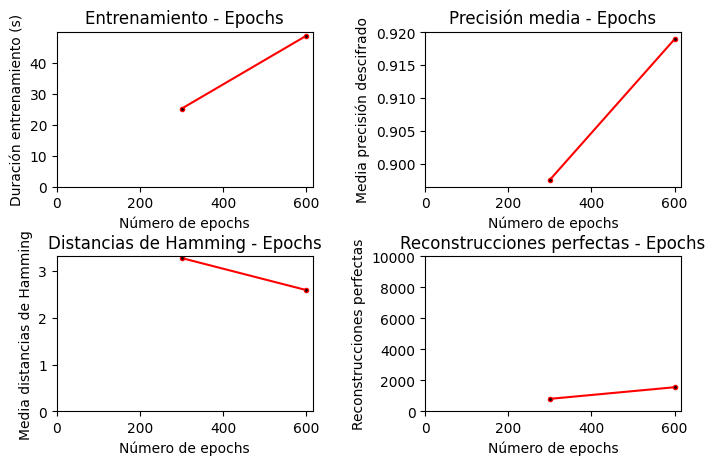

In [9]:
if __name__ == '__main__':


    n_mensajes = 10000
    bits = 32
    batch_size = 512
    adam_optimizer = 0.001
    muestras = 10
    
    epochs = 300
    step = 300
    total_epochs = 600

    res_file_name = f"Resultados_11_{batch_size}_{adam_optimizer}.txt"
    nombre_figura = f"Figura 11 - {batch_size} y {adam_optimizer}"
    with open(res_file_name, "w") as f:
        f.write("-- RESULTADOS DEL EXPERIMENTO 1.1. --\n\n")
            

        diccionario_medidas = {
            "epochs": [],
            "training_times": [],
            "media_precision": [],
            "media_distancias": [],
            "reconstrucciones_perfectas": []
        }

        with open(res_file_name, "a") as f:
            f.write(f"Número de mensajes = {n_mensajes}\n")
            f.write(f"Número de bits = {bits}\n")
            f.write(f"Tamaño del batch = {batch_size}\n")
            f.write(f"Adam optimizer learning rate = {adam_optimizer}\n")
            f.write(f"Epochs totales = {total_epochs}\n")
            f.write(f"Epochs iniciales = {epochs}\n")
            f.write("\n")

        tiempo_inicial = t.time()
        while epochs <= total_epochs:
            
            training_time = entrenar(n_mensajes, bits, epochs, batch_size, adam_optimizer)
            res_list = evaluar(n_mensajes, bits, muestras, res_file_name, epochs)

            media_precision = res_list[0]
            media_distancias = res_list[1]
            reconstrucciones_perfectas = res_list[2]

            diccionario_medidas["epochs"].append(epochs)
            diccionario_medidas["training_times"].append(training_time)
            diccionario_medidas["media_precision"].append(media_precision)
            diccionario_medidas["media_distancias"].append(media_distancias)
            diccionario_medidas["reconstrucciones_perfectas"].append(reconstrucciones_perfectas)

            epochs += step

        tiempo_total = t.time() - tiempo_inicial
        with open(res_file_name, "a") as f:
            f.write(f"Tiempo total de ejecución (s): {tiempo_total}\n\n")
        
        draw_graph(diccionario_medidas, n_mensajes, nombre_figura)